# Create SeqData

In [14]:
# Imports
from pathlib import Path
import seqdata as sd
import matplotlib.pyplot as plt
from eugene import preprocess as pp

In [15]:
# TODO: change to your paths
data_dir = Path("/cellar/users/aklie/opt/rbpnet/examples/data")
fasta = Path("/cellar/users/aklie/opt/rbpnet/examples/data/meta/grch38.chr19.fasta")
peaks = data_dir / "peaks/U2AF2_HepG2/peaks.crosslink.chr19.bed"
signals = [data_dir / "signal/U2AF2_HepG2/eCLIP/counts.pos.bw", data_dir / "signal/U2AF2_HepG2/eCLIP/counts.neg.bw"]
controls = [data_dir / "signal/U2AF2_HepG2/control/counts.pos.bw", data_dir / "signal/U2AF2_HepG2/control/counts.neg.bw"]
control_samples = ['pos', 'neg']
bigwigs = signals + controls
sample_names = ['signal+', 'signal-', 'control+', 'control-']
out = '/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/training/2023_12_25/chr19_HepG2/U2AF2.zarr'
bigwigs, sample_names

([PosixPath('/cellar/users/aklie/opt/rbpnet/examples/data/signal/U2AF2_HepG2/eCLIP/counts.pos.bw'),
  PosixPath('/cellar/users/aklie/opt/rbpnet/examples/data/signal/U2AF2_HepG2/eCLIP/counts.neg.bw'),
  PosixPath('/cellar/users/aklie/opt/rbpnet/examples/data/signal/U2AF2_HepG2/control/counts.pos.bw'),
  PosixPath('/cellar/users/aklie/opt/rbpnet/examples/data/signal/U2AF2_HepG2/control/counts.neg.bw')],
 ['signal+', 'signal-', 'control+', 'control-'])

In [16]:
# Compose a SeqData from a set of files - only run this once!
sdata = sd.from_region_files(
    sd.GenomeFASTA(
        'seq',
        fasta,
        batch_size=2048,
        n_threads=4,
    ),
    sd.BigWig(
        'cov',
        bigwigs,
        sample_names,
        batch_size=2048,
        n_jobs=4,
        threads_per_job=2,
    ),
    path=out,
    fixed_length=500,
    bed=peaks,
    overwrite=True,
    max_jitter=32
)
sdata.load()

100%|██████████| 1788/1788 [00:00<00:00, 3411.47it/s]


<xarray.Dataset>
Dimensions:     (_sequence: 1788, cov_sample: 4, _length: 564)
Coordinates:
  * cov_sample  (cov_sample) object 'signal+' 'signal-' 'control+' 'control-'
Dimensions without coordinates: _sequence, _length
Data variables:
    chrom       (_sequence) object 'chr19' 'chr19' 'chr19' ... 'chr19' 'chr19'
    chromEnd    (_sequence) int64 1373740 13920100 29986552 ... 38709660 6414032
    chromStart  (_sequence) int64 1373176 13919536 29985988 ... 38709096 6413468
    cov         (_sequence, cov_sample, _length) uint16 0 0 0 1 0 ... 0 0 0 1 1
    name        (_sequence) object 'U2AF2_HepG2_rep02' ... 'U2AF2_HepG2_rep02'
    score       (_sequence) float64 6.189 6.111 5.795 ... 2.008 2.006 2.006
    seq         (_sequence, _length) |S1 b'G' b'C' b'T' b'A' ... b'T' b'T' b'T'
    strand      (_sequence) object '+' '+' '+' '+' '+' ... '+' '+' '-' '+' '-'
Attributes:
    length_dim:    _length
    max_jitter:    32
    sequence_dim:  _sequence

In [17]:
# Split cov into control and signal
sdata['control'] = (
    sdata.cov.sel(cov_sample=['control+', 'control-'])
    .rename({'cov_sample': 'cov_strand'})
    .assign_coords({'cov_strand': ['+', '-']})
)
sdata['signal'] = (
    sdata.cov.sel(cov_sample=['signal+', 'signal-'])
    .rename({'cov_sample': 'cov_strand'})
    .assign_coords({'cov_strand': ['+', '-']})
)
sdata = sdata.drop_vars(['cov', 'cov_sample'])

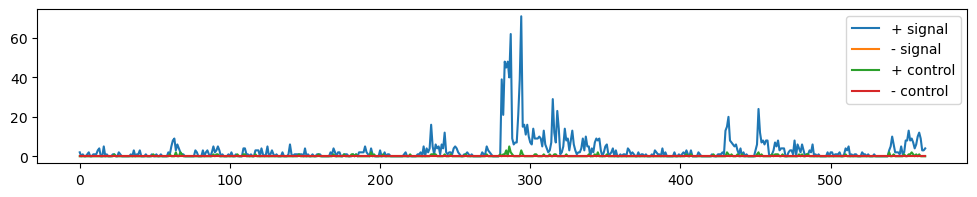

In [18]:
# Plot signal and control
seq_num = 15
fig, ax = plt.subplots(figsize=(12,2))
plt.plot(sdata["signal"][seq_num][0].values, label="+ signal")
plt.plot(sdata["signal"][seq_num][1].values, label="- signal")
plt.plot(sdata["control"][seq_num][0].values, label="+ control")
plt.plot(sdata["control"][seq_num][1].values, label="- control")
plt.legend()

In [19]:
pp.train_test_random_split(sdata, dim="_sequence")

In [20]:
train_sdata = sdata.sel(_sequence=sdata["train_val"])
valid_sdata = sdata.sel(_sequence=~sdata["train_val"])

# Training data

In [23]:
import seqpro as sp

In [24]:
# Define training transformations
from eugene.dataload._augment import RandomRC

def seq_trans(x):
    x = np.char.upper(x)
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    return x

def cov_dtype(x):
    return tuple(arr.astype('f4') for arr in x)

def jitter(x):
    return sp.jitter(*x, max_jitter=32, length_axis=-1, jitter_axes=0)

def to_tensor(x):
    return tuple(torch.tensor(arr, dtype=torch.float32) for arr in x)

def random_rc(x):
    return RandomRC(rc_prob=0.5)(*x)

# Get the train dataloader
train_dl = sd.get_torch_dataloader(
    train_sdata,
    sample_dims=['_sequence'],
    variables=['seq', 'control', 'signal'],
    prefetch_factor=None,
    batch_size=32,
    transforms={
        ('seq', 'control', 'signal'): jitter,
        'seq': seq_trans,
        'signal': lambda x: x[..., 100:-100],
        ('control', 'signal'): cov_dtype,
        ('control', 'seq', 'signal'): to_tensor,
        ('signal', 'control', 'seq'): random_rc
    },
    return_tuples=True,
    shuffle=True,
)

In [33]:
# Test out a prediction batch
batch = next(iter(train_dl))
pred_ctl = model.forward(*batch[:2])
batch[0].shape, batch[1].shape, batch[2].shape, pred_ctl[0].shape, pred_ctl[1].shape

(torch.Size([32, 4, 500]),
 torch.Size([32, 2, 500]),
 torch.Size([32, 2, 300]),
 torch.Size([32, 2, 300]),
 torch.Size([32, 1]))

# Validation data

In [34]:
# Get the validation data
def seq_trans(x):
    x = x[..., 32:-32]
    np.char.upper(x)
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    return torch.as_tensor(x.astype('f4'))

def ctl_trans(x):
    x = x[..., 32:-32]
    return torch.as_tensor(x.astype('f4'))

def cov_trans(x):
    x = x[..., 32+100:-32-100]
    return torch.as_tensor(x.astype('f4'))

X_valid = seq_trans(valid_sdata["seq"].values)
X_ctl_valid = ctl_trans(valid_sdata["control"].values)
y_valid = cov_trans(valid_sdata["signal"].values)
X_valid.shape, X_ctl_valid.shape, y_valid.shape

(torch.Size([179, 4, 500]),
 torch.Size([179, 2, 500]),
 torch.Size([179, 2, 300]))

In [37]:
# Test out a prediction batch
pred_ctl = model.forward(X=X_valid, X_ctl=X_ctl_valid)
pred_ctl[0].shape, pred_ctl[1].shape

(torch.Size([179, 2, 300]), torch.Size([179, 1]))

# Instantiate model

In [43]:
import torch
import numpy as np
from bpnetlite import BPNet

In [44]:
# Create the model, we need 2 channels for the control tracks, 2 channels for the signal tracks, and to trim to 1000 bp of input
model = BPNet(n_outputs=2, n_control_tracks=2, trimming=100)

In [45]:
# Send the model to the GPU
model.cuda()

BPNet(
  (iconv): Conv1d(4, 64, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (rrelus): ModuleList(
    (0-7): 8 x ReLU()
  )
  (fconv): Conv1d(66, 2, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=65, out_features=1, bias=True)
)

# Training

In [46]:
# Quickly define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [48]:
# Use the models fit_generator method to train the model
res = model.fit(
    train_dl,
    optimizer,
    X_valid=X_valid,
    X_ctl_valid=X_ctl_valid,
    y_valid=y_valid,
    max_epochs=250,
    batch_size=128,
    early_stopping=10
)

Epoch	Iteration	Training Time	Validation Time	Training MNLL	Training Count MSE	Validation MNLL	Validation Profile Pearson	Validation Count Pearson	Validation Count MSE	Saved?
0	0	0.0566	0.0073	117.7861	0.4543	54.5381	0.25989097	0.1777473	6.6419	True
1	100	3.0394	0.0075	85.6443	0.3778	57.1393	0.23701872	0.17814831	6.5777	False
3	200	2.7348	0.0074	105.8444	0.2422	53.031	0.2592809	0.17638567	6.1578	True
5	300	2.7283	0.0074	101.3638	0.2635	54.4052	0.24784613	0.17662522	7.0939	False
7	400	2.6947	0.0074	127.6452	0.5192	52.96	0.25361755	0.17711803	6.5531	False
9	500	2.5006	0.0074	96.8297	0.4225	51.5207	0.26843047	0.1786023	6.2399	True
11	600	2.3632	0.0074	92.39	0.252	53.413	0.25099048	0.17781615	5.9751	False
13	700	2.2567	0.0074	118.1437	0.3426	51.6583	0.266935	0.17859334	6.6699	False
15	800	2.1937	0.0074	101.8249	0.3335	51.4455	0.26967335	0.1779829	6.9701	False
17	900	2.0176	0.0074	88.2451	0.2466	50.8048	0.26511374	0.17903472	6.4646	True
19	1000	1.8575	0.0074	92.9302	0.2962	53.3707	0.2584275

# DONE!

----